In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder

In [2]:
folder = r"/home/vladimir/projects/insight/datachallenges/insight/week1/data"
filename = r"employee_retention_data.csv"
path = os.path.join(folder, filename)

In [3]:
# read data from the CSV file
df = pd.read_csv(path)

In [4]:
# convert to datetime format
df['join_date'] = pd.to_datetime(df['join_date'], format="%Y-%m-%d")
df['quit_date'] = pd.to_datetime(df['quit_date'], format="%Y-%m-%d")

In [5]:
# number of days at the company
df['days'] = (df['quit_date'] - df['join_date']).apply(lambda x: getattr(x, 'days'))

In [6]:
# create column indicating whether employee has quit by the last day of the study
df['censored'] = ~df['days'].isna()

In [7]:
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,days,censored
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585.0,True
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,340.0,True
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,NaN,False
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,389.0,True
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1040.0,True


In [8]:
# for employees who haven't quit by the end of the study,
# calculate the total number of days they've been at the company
lastday = pd.datetime.strptime('2015-12-13', "%Y-%m-%d")
index = np.arange(len(df.index))[~df['censored'].values]
df.loc[index, 'days'] = (lastday - df['join_date']).apply(lambda x: getattr(x, 'days'))

In [9]:
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,days,censored
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585.0,True
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,340.0,True
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,426.0,False
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,389.0,True
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1040.0,True


In [10]:
# calculate Kaplan-Meier statistic in order to estimate probability of quitting
time, survival_prob = kaplan_meier_estimator(df["censored"], df["days"])

In [11]:
%matplotlib inline

Text(0.5, 0, 'days $t$')

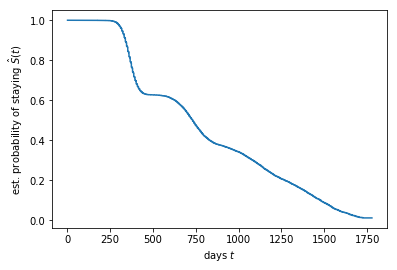

In [12]:
# plotting the survival curve accross all employees
fig_all_together, ax_all_together = plt.subplots(1, 1)

ax_all_together.step(time, survival_prob, where="post")
ax_all_together.set_ylabel("est. probability of staying $\hat{S}(t)$")
ax_all_together.set_xlabel("days $t$")

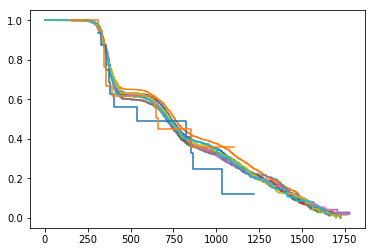

In [13]:
# brief data exploration:
# plot the survival curve by company
company_id_group = df.groupby('company_id')
fig_by_company, ax_by_company = plt.subplots(1, 1)
time_by_company, survival_prob_by_company = [], []
for name in company_id_group.groups:
    group = company_id_group.get_group(name)
    _time_by_company, _survival_prob_by_company = kaplan_meier_estimator(group["censored"],
                                                                         group["days"])
    time_by_company.append(_time_by_company)
    survival_prob_by_company.append(_survival_prob_by_company)
    ax_by_company.step(_time_by_company, _survival_prob_by_company, where='post')

In [14]:
# change the pd.DataFrame index to employee ID
df_by_employee_ID = df.set_index("employee_id", drop=True)

In [15]:
df_by_employee_ID.head()

,company_id,dept,seniority,salary,join_date,quit_date,days,censored
employee_id,,,,,,,,
13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585.0,True
825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,340.0,True
927315.0,4,marketing,14,101000.0,2014-10-13,NaT,426.0,False
662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,389.0,True
256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1040.0,True


In [16]:
# one-hot encoding of the company ID and the department
df_by_employee_ID['company_id'] = df_by_employee_ID['company_id'].astype(str)

In [17]:
dummies = pd.get_dummies(df_by_employee_ID[['company_id', 'dept']])

In [18]:
df_dummied = pd.concat([dummies, df_by_employee_ID.loc[:, ['seniority', 'salary', 'days', 'censored']]], axis=1)

In [19]:
# each column represents probability that employee_id is from company_id_(X)
df_dummied.head()

,company_id_1,company_id_10,company_id_11,company_id_12,company_id_2,company_id_3,company_id_4,company_id_5,company_id_6,company_id_7,...,dept_customer_service,dept_data_science,dept_design,dept_engineer,dept_marketing,dept_sales,seniority,salary,days,censored
employee_id,,,,,,,,,,,,,,,,,,,,,
13021.0,0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,28,89000.0,585.0,True
825355.0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,20,183000.0,340.0,True
927315.0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,14,101000.0,426.0,False
662910.0,0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,20,115000.0,389.0,True
256971.0,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,23,276000.0,1040.0,True


In [20]:
# use Cox survival analysis to fit a logistic regression
data_x = df_dummied.iloc[:, slice(None, -2)]
data_y = df_dummied.loc[:, ['censored', 'days']]
estimator = CoxPHSurvivalAnalysis(alpha=0, n_iter=1000, tol=1e-06, verbose=0)
estimator.fit(data_x, data_y.to_records(index=False))

/home/vladimir/anaconda3/envs/datachallenges/lib/python3.6/site-packages/sksurv/linear_model/coxph.py:208: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.667913e-26
  overwrite_a=False, overwrite_b=False, check_finite=False)
/home/vladimir/anaconda3/envs/datachallenges/lib/python3.6/site-packages/sksurv/linear_model/coxph.py:208: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.067659e-25
  overwrite_a=False, overwrite_b=False, check_finite=False)
/home/vladimir/anaconda3/envs/datachallenges/lib/python3.6/site-packages/sksurv/linear_model/coxph.py:208: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number8.696647e-26
  overwrite_a=False, overwrite_b=False, check_finite=False)


CoxPHSurvivalAnalysis(alpha=0, n_iter=1000, tol=1e-06, verbose=0)

In [21]:
# print out the result of fitting
# float values are the log hazard ratio
pd.Series(estimator.coef_, index=data_x.columns)

company_id_1            -0.337295
company_id_10           -0.341651
company_id_11           -0.129383
company_id_12           -0.325045
company_id_2            -0.393370
company_id_3            -0.331348
company_id_4            -0.319797
company_id_5            -0.355249
company_id_6            -0.351104
company_id_7            -0.365287
company_id_8            -0.344233
company_id_9            -0.361593
dept_customer_service    1.464326
dept_data_science        1.507931
dept_design              1.549541
dept_engineer            1.480378
dept_marketing           1.571853
dept_sales               1.618501
seniority                0.009686
salary                  -0.000002
dtype: float64

In [22]:
print(
    """
    There's little difference among log hazard ratios
    by company, department, seniority or salary. None
    of the variables appear to be predictive.
    """
)


    There's little difference among log hazard ratios
    by company, department, seniority or salary. None
    of the variables appear to be predictive.
    
